In [2]:
from dataset import BufferedGeoDataLoader
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

import pytorch_lightning as pl

In [2]:
geodata = BufferedGeoDataLoader(fold_id=0, num_wokers=8)

In [3]:
from project.pl_models.tcn_model import TemporalConvNetPL
from project.utils.torch_utils import count_parameters

In [4]:
tcn = TemporalConvNetPL(
    num_inputs=geodata.num_features_hourly, num_geofactors=geodata.num_features_static, num_outputs=1, num_hidden=32, num_layers=3, dropout=0.2, static_dropout=0.2, kernel_size=3,
    tasks='fvc', lr=0.001, weight_decay=0.001)

In [5]:
trainer = pl.Trainer(accelerator='gpu', devices=[7])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(tcn, datamodule=geodata)

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name             | Type            | Params
-----------------------------------------------------
0 | loss_fn          | RegressionLoss  | 0     
1 | encode_static    | FeedForward     | 2.5 K 
2 | flatten_time     | Transform       | 0     
3 | to_sequence_last | Transform       | 0     
4 | tcn              | TemporalConvNet | 18.8 K
5 | tcn_mean         | TemporalConvNet | 7.5 K 
6 | tcn_var          | TemporalConvNet | 7.5 K

Sanity Checking: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:178: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


tensor([[[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        ...,

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]],

        [[3.4539e+16],
         [3.4539e+16],
         [3.4539e+16],
         ...,
         [       nan],
         [       nan],
         [       nan]]], device='cuda:7')
tensor([[[3.4539e+16],
         [3.4539e+16],

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:132: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [15]:
tcn(batch.f_hourly, batch.f_static)

tensor([[[0.0125],
         [0.0167],
         [0.0180],
         ...,
         [0.0172],
         [0.0154],
         [0.0175]],

        [[0.0130],
         [0.0169],
         [0.0162],
         ...,
         [0.0173],
         [0.0167],
         [0.0143]],

        [[0.0127],
         [0.0160],
         [0.0170],
         ...,
         [0.0163],
         [0.0171],
         [0.0157]],

        ...,

        [[0.0123],
         [0.0167],
         [0.0166],
         ...,
         [0.0155],
         [0.0182],
         [0.0174]],

        [[0.0140],
         [0.0176],
         [0.0186],
         ...,
         [0.0180],
         [0.0176],
         [0.0169]],

        [[0.0123],
         [0.0161],
         [0.0179],
         ...,
         [0.0177],
         [0.0173],
         [0.0165]]], grad_fn=<PermuteBackward0>)

In [6]:
train_loader = geodata.train_dataloader()

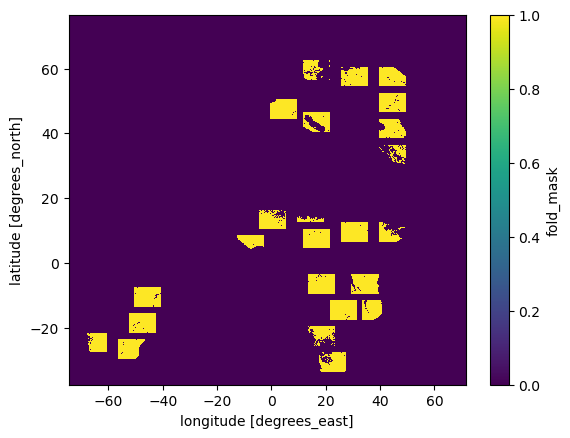

In [7]:
train_loader.dataset.mask.plot()

In [8]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  0%|                                       | 2/2213 [00:57<17:45:35, 28.92s/it]
Traceback (most recent call last):
  File "/raid/scratch/tmp/ipykernel_46646/161158528.py", line 5, in <module>
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1316, in _next_data
    idx, data = self._get_data()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1282, in _get_data
    success, data = self._try_get_data()
  File "/Net/Groups/BGI/peopl

In [11]:
batch.f_hourly.shape

torch.Size([50, 24, 1000, 4])

In [12]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [13]:
batch.f_static.shape

torch.Size([50, 6])

In [14]:
b.f_static.shape

torch.Size([50, 6])

RuntimeError: Given groups=1, weight of size [32, 4, 3], expected input[50, 24000, 4] to have 4 channels, but got 24000 channels instead

In [19]:
import matplotlib.pyplot as plt

In [44]:
b.f_hourly = b.f_hourly.view(b.f_hourly.shape[0], -1, b.f_hourly.shape[-1])

AttributeError: can't set attribute

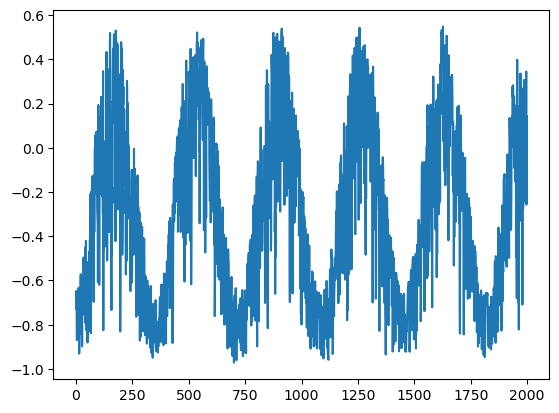

In [43]:
plt.plot(br[49, :2000, 1])

In [14]:
b.f_hourly.shape

torch.Size([50, 24, 7305, 4])

In [5]:
count_parameters(tcn)

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
| feedforward_static.model.linear00.weight |    192     |
|  feedforward_static.model.linear00.bias  |     32     |
| feedforward_static.model.linear01.weight |    256     |
|  feedforward_static.model.linear01.bias  |     8      |
|           tcn.tcn.0.conv1.bias           |     32     |
|         tcn.tcn.0.conv1.weight_g         |     32     |
|         tcn.tcn.0.conv1.weight_v         |    384     |
|           tcn.tcn.0.conv2.bias           |     32     |
|         tcn.tcn.0.conv2.weight_g         |     32     |
|         tcn.tcn.0.conv2.weight_v         |    3072    |
|     tcn.tcn.0.res.downsample.weight      |    152     |
|      tcn.tcn.0.res.downsample.bias       |     38     |
|           tcn.tcn.1.conv1.bias           |     32     |
|         tcn.tcn.1.conv1.weight_g         |     32     |
|         tcn.

19347

In [3]:
tcn

TemporalConvNetPL(
  (feedforward_static): FeedForward(
    (model): Sequential(
      (linear00): Linear(in_features=6, out_features=32, bias=True)
      (dropout00): Dropout(p=0.2, inplace=False)
      (activation00): ReLU()
      (linear01): Linear(in_features=32, out_features=8, bias=True)
      (dropout01): Dropout(p=0.2, inplace=False)
      (activation01): Tanh()
    )
  )
  (tcn): TemporalConvNet(
    (to_sequence_last): Transform()
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (res): Residual(
          (downsample): Conv1d(4, 38, kernel_size=(1,), stride=(1,))
        )
        (relu): ReLU()
      )
      (1): Tem

In [ ]:
import time

class Dataset(object):
    def __init__(self, max_items = 5):
        self.max_items = max_items
        self.chunks = []

    def add_item(self, x):
        self.chunks.appendd(x)

    def get_item(self, n):
        if len(self.chunks) >= 0
            result = [self.chunks.pop() for _ in range(n)]
        else:
            raise StopIteration

        time.sleep(0.1)

        return 


In [61]:
import threading
import queue

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = queue.Queue(1)
        self.generator = generator
        self.daemon = True
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
            next_item = self.queue.get()
            if next_item is None:
                 raise StopIteration
            return next_item

In [62]:
def generate(n):
    for i in range(n):
        yield i

In [64]:
bgen = BackgroundGenerator(generator=generate(10))

In [ ]:
bgen.next()

0

In [69]:
bgen.run()

KeyboardInterrupt: 

Consumer: Running
Producer: Running
>put value 0 (1 total)
>put value 1 (2 total)
>get value 0 (1 total)
>put value 2 (2 total)>got 0

>put value 3 (3 total)
>put value 4 (4 total)
>put value 5 (5 total)
>get value 1 (4 total)
>got 1
>put value 6 (5 total)
>get value 2 (4 total)
>got 2
>put value 7 (5 total)
>get value 3 (4 total)
>got 3>put value 8 (5 total)

>get value 4 (4 total)
>got 4>put value 9 (5 total)

Producer: Done
>get value 5 (4 total)
>got 5
>get value 6 (3 total)
>got 6
>get value 7 (2 total)
>got 7
>get value 8 (1 total)
>got 8
>get value 9 (0 total)
>got 9


KeyboardInterrupt: 

In [76]:
# SuperFastPython.com
# example of using the simple queue among processes
from time import sleep
from random import random
from multiprocessing import Process
from multiprocessing import SimpleQueue
 
# generate work
def producer(queue):
    print('Producer: Running', flush=True)
    # generate work
    for i in range(10):
        # generate a value
        value = random()
        # block
        #sleep(value)
        # add to the queue
        print('Put value')
        queue.put(value)
    # all done
    queue.put(None)
    print('Producer: Done', flush=True)
 
# consume work
def consumer(queue):
    print('Consumer: Running', flush=True)
    # consume work
    while True:
        # get a unit of work
        item = queue.get()
        # check for stop
        if item is None:
            break
        # report
        print(f'>got {item}', flush=True)
        sleep(1)
    # all done
    print('Consumer: Done', flush=True)
 
# create the shared queue
queue = SimpleQueue()
# start the consumer
consumer_process = Process(target=consumer, args=(queue,))
consumer_process.start()
# start the producer
producer_process = Process(target=producer, args=(queue,))
producer_process.start()
# wait for all child processes to finish
producer_process.join()
consumer_process.join()

Consumer: Running
Producer: Running
Put value
>got 0.5167574710624812Put value

Put value
Put value
Put value
Put value
Put value
Put value
Put value
Put value
Producer: Done
>got 0.8092434984658852
>got 0.31689718979925574
>got 0.820357973428891
>got 0.3068956683358398
>got 0.3917735942309919
>got 0.7456238883130152
>got 0.6774774386586543
>got 0.5731500276208481
>got 0.27763739356529193
Consumer: Done


In [73]:
queue

AttributeError: 'SimpleQueue' object has no attribute 'qsize'

In [60]:

import torch
from torch.utils.data import IterableDataset, DataLoader
import time
import numpy as np


In [61]:
# SuperFastPython.com
# example of using the simple queue among processes
import torch.multiprocessing as mpl
from torch.multiprocessing import Process, SimpleQueue
from time import sleep
from random import random

#n_enqueued = mpl.Value('i', 0)

# generate work
def producer(queue, n_enqueued):
    print('Producer: Running', flush=True)
    # generate work
    current_value = 0
    exit = False
    while True:
        if exit:
            break

        if n_enqueued.value < 5:
            # add to the queue
            queue.put(current_value)
            with n_enqueued.get_lock():
                n_enqueued.value += 1
                print(f'>put value {current_value} ({n_enqueued.value} total)')

            current_value += 1

            if current_value >= 10:
                exit = True

        else:
            sleep(0.5)

    # all done
    queue.put(None)
    print('Producer: Done', flush=True)


In [64]:
class Buffer(object):
    def __init__(self):
        self.queue = SimpleQueue()
        self.n_enqueued = mpl.Value('i', 0)

        self.producer_process = Process(target=producer, args=(self.queue, self.n_enqueued,))
        self.producer_process.start()

    def next(self):
        while True:
            if self.n_enqueued.value < 1:
                sleep(1)
                continue

            with self.n_enqueued.get_lock():
                self.n_enqueued.value -= 1

            value = self.queue.get()
            print(f'>get value {value} ({self.n_enqueued.value} total)')
            return value

    def terminate(self):
        self.producer_process.join()


class Data(IterableDataset):
    def __init__(self):
        super().__init__()

    def __iter__(self):
        queue = SimpleQueue()
        buffer = Buffer()

        while True:
            el = buffer.next()

            if el is None:
                buffer.terminate()
                break

            print(el)

            yield el


data = Data()
dataloader = DataLoader(data, prefetch_factor=2, num_workers=1)


In [65]:
if __name__ == '__main__':
    for d in dataloader:
        sleep(0.5)
        print(d)

AssertionError: Caught AssertionError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 34, in fetch
    data.append(next(self.dataset_iter))
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 32, in __iter__
    buffer = Buffer()
  File "/raid/scratch/tmp/ipykernel_23727/3276945696.py", line 7, in __init__
    self.producer_process.start()
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/multiprocessing/process.py", line 118, in start
    assert not _current_process._config.get('daemon'), \
AssertionError: daemonic processes are not allowed to have children


In [28]:
import torch.multiprocessing as mp

In [36]:
class A(object):
    def __init__(self):
        self.n = 0

    def increase(self):
        self.n += 1

In [37]:
processes = []
aaa = []
for _ in range(2):
    a = A()

    aaa.append(a)
    process = mp.Process(target=a.increase)
    process.start()
    processes.append(process)

for process in processes:
    process.join()


In [39]:
aaa[1].n

0

In [41]:
import xarray as xr
import numpy as np

In [53]:
mask = xr.DataArray(np.random.choice(2, size=(10, 10)), dims=['lat', 'lon'], coords={'lat': np.arange(10), 'lon': np.arange(10)})

In [67]:
np.argwhere(mask.stack(sample=('lat', 'lon')).values).squeeze()

array([ 0,  2,  3,  5,  7, 10, 12, 15, 16, 17, 18, 20, 21, 22, 26, 27, 28,
       30, 32, 33, 37, 42, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58,
       62, 64, 65, 66, 67, 69, 73, 76, 77, 79, 80, 84, 86, 87, 89, 91, 93,
       95, 98, 99])

In [54]:
mask_flat = mask.stack(sample=('lat', 'lon')).reset_coords()
mask_flat

ValueError: cannot reset_coords with drop=False on an unnamed DataArrray

In [92]:
m = mask_flat.where(mask_flat, drop=True)

In [93]:
m

<xarray.DataArray (sample: 52)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) int64 0 0 0 0 1 1 1 1 1 1 2 2 ... 7 7 7 8 8 8 8 8 8 8 8 9
  * lon      (sample) int64 0 1 4 7 0 1 2 4 5 6 0 3 ... 6 8 9 1 2 4 5 6 7 8 9 4

In [68]:
np.random.shuffle([1])

In [3]:
import torch.multiprocessing as mp
import queue

In [8]:
q = mp.Manager().Queue()

In [9]:
try:
    q.get(block=False)
    print('try')
except queue.Empty:
    print('empty')

empty


: 

In [1]:
import xarray as xr

In [2]:
order = xr.open_dataset('../order.nc')
count = xr.open_dataset('../count.nc')

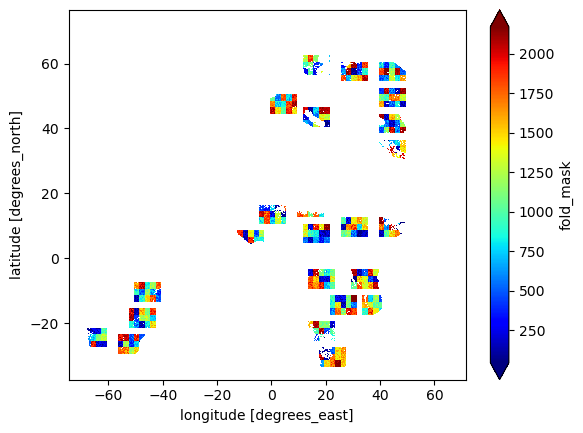

In [4]:
order.fold_mask.plot(robust=True, cmap='jet')

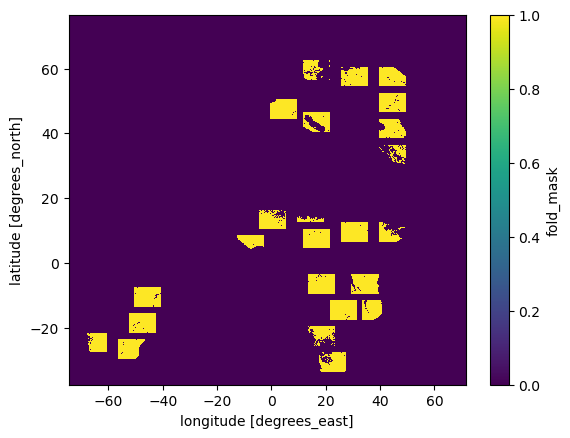

In [3]:
count.fold_mask.plot()

In [4]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr').fold_mask

In [5]:
mask = mask.chunk({'lat': -1, 'lon': -1})

In [7]:
mask = mask.load()

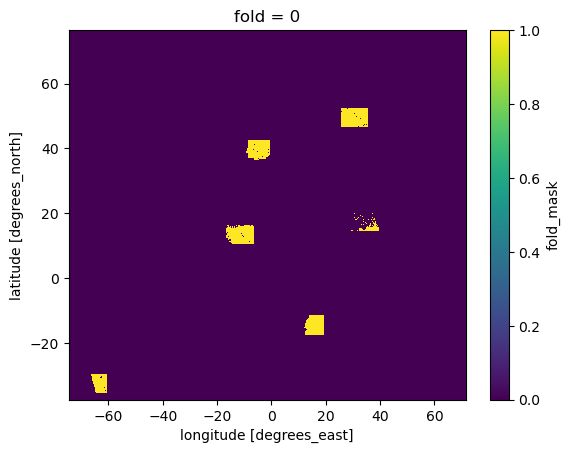

In [14]:
mask.isel(fold=0).plot()

In [33]:
import xarray as xr
import numpy as np
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr')

mask = ds.mask.load()
chunk_mask = (mask.coarsen(lat=20, lon=20).sum()) > 200
lat_min, lon_min = np.argwhere(chunk_mask.values)[0] * 20
lat_max, lon_max = (np.argwhere(chunk_mask.values)[0] + 1) * 20
mask  = mask.isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).load()
data  = ds[['fvc']].isel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice(1000, 1100)).load()

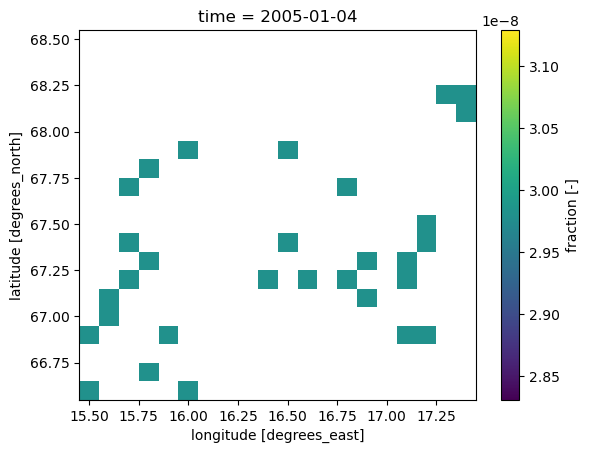

In [34]:
data.fvc.isel(time=-1).plot()

In [48]:
class DataChunk(object):
    """Defines a single chunk and how to retreive data from it."""
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            shuffle: bool = False) -> None:

        data = data.load()
        mask = mask.load()

        mask = mask.stack(sample=('lat', 'lon')).reset_coords(drop=True).load()
        data = data.stack(sample=('lat', 'lon')).reset_coords(drop=True)
        self.data = data.where(mask, drop=True).load()

        self.shuffle = shuffle

        self.coords = self._get_coords()

        self._current_sample = 0

    def _get_coords(self):
        coords = np.arange(len(self.data.sample))
        if self.shuffle:
            np.random.shuffle(coords)
        return coords


In [49]:
dc = DataChunk(data=data, mask=mask)

In [50]:
dc.data.isel(sample=0).lat.item()

68.5

In [51]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [37]:
dc.data

<xarray.Dataset>
Dimensions:  (time: 100, sample: 273)
Coordinates:
  * time     (time) datetime64[ns] 2004-09-27 2004-09-28 ... 2005-01-04
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.6 15.7 15.8 16.1 16.2 ... 17.1 17.2 17.3 17.4
Data variables:
    fvc      (time, sample) float32 2.98e-08 nan nan nan nan ... nan nan nan nan

In [38]:
dc.mask

<xarray.DataArray 'mask' (sample: 400)>
array([False,  True,  True,  True, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True,  True, False, False,  True, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        True, False, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
  * sample   (sample) object MultiIndex
  * lat      (sample) float32 68.5 68.5 68.5 68.5 68.5 ... 66.6 66.6 66.6 66.6
  * lon      (sample) float32 15.5 15.6 15.7 15.8 15.9 ... 17.1 17.2 17.3 17.4

In [1]:
def iterate():
    i = 0
    try:
        while True:
            result = i
            i += 1
            if i == 5:
                return
            yield result
    finally:
        print('finally')

In [3]:
for j in range(2):
    for i in iterate():
        print(i)

0
1
2
3
finally
0
1
2
3
finally


In [6]:
import xarray as xr

mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr').fold_mask

In [8]:
ind_x = xr.DataArray([76.5,  76.4], dims=["x"])
ind_y = xr.DataArray([-74.5, -74.4], dims=["y"])

In [9]:
mask[ind_x, ind_y]

TypeError: invalid indexer array, does not have integer dtype: array([76.5, 76.4])

In [1]:
from dataset import GeoDataQueue
from collections import namedtuple

ReturnPattern = namedtuple('ReturnPattern', 'mean_hat var_hat coords')


geodata = GeoDataQueue(
    fold_id=0,
    batch_size=4,
    chunk_buffer_size=4,
    num_queue_workers=12,
)

geodata.setup('predict')
pdl = geodata.predict_dataloader()

class Trainer(object):
    def __init__(self, dataloader):
        self.predict_dataloaders = [dataloader]
        self.log_dir = './'

trainer = Trainer(pdl)


In [46]:
from pytorch_lightning.callbacks import BasePredictionWriter
import xarray as xr
import os
import shutil
import logging
import numpy as np
import torch.multiprocessing as mp
from time import sleep

from typing import Any, Sequence

from dataset import QueueFiller

Coords = namedtuple('Coords', 'lat, lon, chunk')

logger = logging.getLogger('user_logger')

class OutputWriter(BasePredictionWriter):

    def __init__(
            self,
            targets: str | list[str],
            overwrite: bool | str = True) -> None:
        super().__init__(write_interval='batch')

        self.targets = [targets] if isinstance(targets, str) else targets
        self.overwrite = overwrite

        self.zarr_file: str | None = None

        self.processes: list[mp.Process] = []
        self.chunks = {}

    def write_on_batch_end(
            self,
            trainer: 'pl.Trainer',
            pl_module: 'pl.LightningModule',
            prediction: Any,
            batch_indices: Sequence[int] | None,
            batch: Any,
            batch_idx: int,
            dataloader_idx: int) -> None:

        if self.zarr_file is None:
            self.has_variance = prediction.var_hat is not None
            self.zarr_file, self.mask, self.chunk_coords, chunk_size = self.init_zarr(
                trainer=trainer, dataloader_idx=dataloader_idx, has_variance=self.has_variance)
            self.chunk_bounds_lat = QueueFiller.coords2bounds(self.mask, dim='lat', chunk_size=chunk_size)
            self.chunk_bounds_lon = QueueFiller.coords2bounds(self.mask, dim='lon', chunk_size=chunk_size)

        for i in range(len(prediction.coords.chunk)):
            i_pred = self.subset_namedtuple(prediction, i)
            chunk_id = i_pred.coords.chunk

            if chunk_id not in self.chunks:
                chunk_lat, chunk_lon = self.chunk_coords[chunk_id]

                lat_bounds = slice(*self.chunk_bounds_lat[chunk_lat])
                lon_bounds = slice(*self.chunk_bounds_lon[chunk_lon])
                num_samples = self.mask.isel(lat=lat_bounds, lon=lon_bounds).sum().compute()

                chunk_ds = self.get_target_like(
                    self.zarr_file.isel(lat=lat_bounds, lon=lon_bounds),
                    has_variance=self.has_variance,
                    use_orig_name=False
                )

                self.chunks[chunk_id] = {
                    'ds': chunk_ds,
                    'num_samples': num_samples,
                    'num_saved': 0,
                    'lat_bounds': lat_bounds,
                    'lon_bounds': lon_bounds,
                }

            for target_i, target in enumerate(self.targets):
                self.chunks[chunk_id]['ds'][
                    self.get_target_pred_name(name=target, is_variance=False)
                ].loc[{'lat': i_pred.coords.lat, 'lon': i_pred.coords.lon}] = i_pred.mean_hat[..., target_i]

                if self.has_variance:
                    self.chunks[chunk_id]['ds'][
                        self.get_target_pred_name(name=target, is_variance=True)
                    ].loc[{'lat': i_pred.coords.lat, 'lon': i_pred.coords.lon}] = i_pred.var_hat[..., target_i]

            self.chunks[chunk_id]['num_saved'] += 1

            if self.chunks[chunk_id]['num_saved'] == self.chunks[chunk_id]['num_samples']:
                process = mp.Process(target=self.write_chunk, args=(self.chunks[chunk_id],))
                self.processes.append(process)
                print(f'Start process, currently {len(self.processes)} write processes alive.')
                del self.chunks[chunk_id]
                process.start()

            remove_processes = []
            for process_i, process in enumerate(self.processes):
                if not process.is_alive():
                    remove_processes.append(process_i)

            if len(remove_processes) > 0:
                print(f'Terminating {len(remove_processes)} write processes.')

                for process_i in reversed(remove_processes):
                    process = self.processes.pop(process_i)
                    process.terminate()
                    process.join()

    def write_chunk(self, chunk: dict) -> None:
        chunk_ds = chunk['ds'].drop_vars(['time'])

        chunk_ds.to_zarr(self.zarr_file.encoding['source'], consolidated=True, region={
            'lat': chunk['lat_bounds'],
            'lon': chunk['lon_bounds']
        })

    def init_zarr(
            self, trainer: 'pl.Trainer',
            dataloader_idx: int,
            has_variance: bool) -> tuple[xr.Dataset, xr.DataArray, np.typing.ArrayLike, int]:

        zarr_dir = os.path.join(trainer.log_dir, 'predictions.zarr')

        if os.path.isdir(zarr_dir):
            if self.overwrite:
                shutil.rmtree(zarr_dir)

            else:
                raise FileExistsError(
                    f'The zar file {zarr_dir} already exists. Set `OutputWriter(..., overwrite=True)` '
                    'to overwrite the file.'
                )

        dataset = trainer.predict_dataloaders[dataloader_idx].dataset
        data = dataset.data

        missing_targets = []
        for target in self.targets:
            if not target in data.data_vars:
                missing_targets.append(target)

        if len(missing_targets) > 0:
            raise KeyError(
                f'some target(s) missing in dataset: {missing_targets}.'
            )

        dummy = self.get_target_like(data, has_variance=has_variance, use_orig_name=True)
        dummy.to_zarr(zarr_dir, compute=False)

        return xr.open_zarr(zarr_dir), dataset.mask, dataset.chunk_coords, dataset.chunk_size

    def get_target_like(self, data: xr.Dataset, has_variance: bool, use_orig_name: bool) -> xr.Dataset:
        dummy = xr.Dataset()
        for target in self.targets:
            name = target if use_orig_name else self.get_target_pred_name(name=target, is_variance=False)
            dummy[self.get_target_pred_name(name=target, is_variance=False)] = data[name]
            if has_variance:
                dummy[self.get_target_pred_name(name=target, is_variance=True)] = data[name]

        return xr.full_like(dummy, fill_value=np.nan)

    @staticmethod
    def get_target_pred_name(name: str, is_variance: bool) -> bool:
        if is_variance:
            return name + '_vhat'
        else:
            return name + '_hat'

    @staticmethod
    def isnamedtuple(obj) -> bool:
        return (
                isinstance(obj, tuple) and
                hasattr(obj, '_asdict') and
                hasattr(obj, '_fields')
        )

    def subset_namedtuple(self: 'OutputWriter', x: namedtuple, ind: int) -> namedtuple:
        el_type = type(x)

        el_list = []
        for el in x:
            if self.isnamedtuple(el):
                el_subset = self.subset_namedtuple(el, ind)
            elif el is None:
                el_subset = None
            else:
                el_subset = el[ind]
                if el_subset.ndim == 0:
                    el_subset = el_subset.item()
                else:
                    el_subset = el_subset.numpy()

            el_list.append(el_subset)

        return el_type(*el_list)

In [47]:
output_writer = OutputWriter(targets='fvc_ano')

In [48]:
from tqdm import tqdm

In [49]:
for i, batch in tqdm(enumerate(pdl), total=len(pdl)):
    #pred = ReturnPattern(mean_hat=batch.t_daily, var_hat=batch.t_daily.abs() * 2, coords=batch.coords)
    pred = ReturnPattern(mean_hat=batch.t_daily, var_hat=None, coords=batch.coords)
    output_writer.write_on_batch_end(trainer=trainer, pl_module=None, prediction=pred, batch_indices=None, batch=None, batch_idx=None, dataloader_idx=0)

  0%|          | 4/7487 [00:19<7:41:02,  3.70s/it] 

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 10/7487 [00:19<2:04:32,  1.00it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 13/7487 [00:19<1:18:51,  1.58it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 19/7487 [00:20<36:48,  3.38it/s]  

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 25/7487 [00:20<19:54,  6.25it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Start process, currently 1 write processes alive.


  0%|          | 28/7487 [00:20<15:53,  7.83it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 34/7487 [00:20<10:24, 11.93it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  0%|          | 37/7487 [00:20<08:51, 14.01it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Terminating 1 write processes.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 40/7487 [00:21<07:43, 16.05it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 43/7487 [00:21<07:05, 17.48it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 46/7487 [00:21<06:41, 18.55it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Start process, currently 1 write processes alive.


  1%|          | 49/7487 [00:21<06:28, 19.14it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 52/7487 [00:21<05:59, 20.68it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 55/7487 [00:21<05:38, 21.95it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 58/7487 [00:21<05:26, 22.75it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 64/7487 [00:22<05:07, 24.14it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 67/7487 [00:22<05:40, 21.79it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 70/7487 [00:22<05:19, 23.23it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 73/7487 [00:22<05:06, 24.21it/s]

Checking processes in trial 0.
Terminating 1 write processes.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 76/7487 [00:22<05:37, 21.95it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 79/7487 [00:22<05:29, 22.50it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 82/7487 [00:22<05:13, 23.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 85/7487 [00:22<05:08, 24.02it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|          | 88/7487 [00:23<05:07, 24.05it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 94/7487 [00:23<04:57, 24.84it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 97/7487 [00:23<04:57, 24.82it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 100/7487 [00:23<05:05, 24.20it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 103/7487 [00:23<05:03, 24.35it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 106/7487 [00:23<05:03, 24.32it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  1%|▏         | 109/7487 [00:23<05:04, 24.22it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 115/7487 [00:24<04:58, 24.71it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 121/7487 [00:24<04:55, 24.93it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 124/7487 [00:24<04:53, 25.05it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 127/7487 [00:24<04:51, 25.29it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 130/7487 [00:24<04:46, 25.65it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 133/7487 [00:24<04:51, 25.24it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 136/7487 [00:25<04:48, 25.51it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 142/7487 [00:25<04:48, 25.48it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 148/7487 [00:25<04:46, 25.58it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 151/7487 [00:25<04:54, 24.91it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 154/7487 [00:25<04:51, 25.13it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 157/7487 [00:25<04:51, 25.14it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 160/7487 [00:25<04:47, 25.45it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 163/7487 [00:26<04:47, 25.45it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 169/7487 [00:26<04:45, 25.61it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 175/7487 [00:26<04:36, 26.44it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 181/7487 [00:26<04:52, 25.01it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 184/7487 [00:26<04:54, 24.79it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  2%|▏         | 187/7487 [00:27<04:47, 25.38it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 190/7487 [00:27<04:45, 25.53it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 196/7487 [00:27<04:37, 26.31it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 202/7487 [00:27<04:37, 26.24it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 208/7487 [00:27<04:39, 26.08it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 214/7487 [00:28<04:41, 25.86it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 217/7487 [00:28<04:43, 25.67it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 220/7487 [00:28<04:44, 25.57it/s]

Checking processes in trial 0.


  3%|▎         | 223/7487 [00:28<04:40, 25.93it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 229/7487 [00:28<04:38, 26.03it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 235/7487 [00:28<04:27, 27.11it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 241/7487 [00:29<04:28, 26.99it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 247/7487 [00:29<04:23, 27.45it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 253/7487 [00:29<04:30, 26.77it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 259/7487 [00:29<04:32, 26.54it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  3%|▎         | 262/7487 [00:29<05:03, 23.80it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▎         | 268/7487 [00:30<05:05, 23.64it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▎         | 274/7487 [00:30<05:04, 23.69it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▎         | 280/7487 [00:30<04:50, 24.81it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 283/7487 [00:30<04:57, 24.21it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 289/7487 [00:31<04:51, 24.73it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 295/7487 [00:31<04:46, 25.15it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 298/7487 [00:31<05:16, 22.70it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 304/7487 [00:31<04:51, 24.61it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 310/7487 [00:31<04:36, 25.97it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 316/7487 [00:32<04:30, 26.50it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 323/7487 [00:32<04:21, 27.35it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 329/7487 [00:32<04:19, 27.55it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 332/7487 [00:32<04:17, 27.78it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  4%|▍         | 335/7487 [00:33<09:23, 12.70it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 344/7487 [00:33<05:58, 19.90it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 347/7487 [00:33<05:31, 21.52it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 353/7487 [00:33<04:58, 23.90it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 359/7487 [00:34<04:37, 25.64it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 365/7487 [00:34<04:29, 26.42it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▍         | 371/7487 [00:34<04:28, 26.51it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 377/7487 [00:34<04:32, 26.06it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 383/7487 [00:34<04:28, 26.46it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 389/7487 [00:35<04:32, 26.02it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 395/7487 [00:35<04:35, 25.73it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 398/7487 [00:35<04:53, 24.16it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 404/7487 [00:35<04:34, 25.78it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  5%|▌         | 410/7487 [00:36<04:27, 26.44it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 416/7487 [00:36<04:20, 27.12it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 422/7487 [00:36<04:13, 27.85it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 428/7487 [00:36<04:19, 27.18it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 434/7487 [00:36<04:14, 27.74it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 440/7487 [00:37<04:18, 27.22it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 446/7487 [00:37<04:16, 27.48it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 452/7487 [00:37<04:10, 28.10it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 458/7487 [00:37<04:22, 26.73it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 464/7487 [00:37<04:20, 26.92it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▌         | 467/7487 [00:38<04:20, 26.90it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▋         | 473/7487 [00:38<04:28, 26.09it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▋         | 479/7487 [00:38<04:17, 27.25it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  6%|▋         | 485/7487 [00:38<04:18, 27.04it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 491/7487 [00:38<04:11, 27.77it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 497/7487 [00:39<04:10, 27.86it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 503/7487 [00:39<04:17, 27.15it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 509/7487 [00:39<04:14, 27.45it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 515/7487 [00:39<04:45, 24.39it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 518/7487 [00:40<04:41, 24.73it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 524/7487 [00:40<04:27, 26.07it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 530/7487 [00:40<04:48, 24.08it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 536/7487 [00:40<04:35, 25.26it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 539/7487 [00:40<05:02, 22.96it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 545/7487 [00:41<04:43, 24.48it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 551/7487 [00:41<05:00, 23.07it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 554/7487 [00:41<04:48, 24.06it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  7%|▋         | 560/7487 [00:41<04:28, 25.80it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 566/7487 [00:41<04:20, 26.56it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 572/7487 [00:42<04:40, 24.65it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 575/7487 [00:42<04:44, 24.27it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 581/7487 [00:42<07:50, 14.67it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 587/7487 [00:43<05:58, 19.23it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 593/7487 [00:43<05:05, 22.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 596/7487 [00:43<04:48, 23.91it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 602/7487 [00:43<04:32, 25.31it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 608/7487 [00:43<04:22, 26.21it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 614/7487 [00:44<04:20, 26.38it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 620/7487 [00:44<04:17, 26.67it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 626/7487 [00:44<04:44, 24.11it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 632/7487 [00:44<04:35, 24.85it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  8%|▊         | 635/7487 [00:45<04:32, 25.18it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▊         | 644/7487 [00:45<04:13, 27.04it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▊         | 647/7487 [00:45<04:11, 27.16it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▊         | 653/7487 [00:45<04:12, 27.03it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 659/7487 [00:45<04:10, 27.26it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 665/7487 [00:46<04:13, 26.89it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 671/7487 [00:46<04:13, 26.85it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 677/7487 [00:46<04:16, 26.51it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 683/7487 [00:46<04:16, 26.53it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 689/7487 [00:47<04:16, 26.53it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 695/7487 [00:47<04:20, 26.05it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 701/7487 [00:47<04:11, 26.94it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 704/7487 [00:47<04:09, 27.22it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


  9%|▉         | 710/7487 [00:47<04:32, 24.87it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 716/7487 [00:48<04:19, 26.10it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 722/7487 [00:48<04:12, 26.84it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 728/7487 [00:48<04:24, 25.56it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 734/7487 [00:48<04:18, 26.13it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 740/7487 [00:48<04:10, 26.97it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|▉         | 746/7487 [00:49<04:07, 27.27it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 752/7487 [00:49<04:12, 26.69it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 755/7487 [00:49<04:18, 26.06it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 761/7487 [00:49<04:30, 24.87it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 767/7487 [00:50<04:24, 25.38it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 773/7487 [00:50<04:22, 25.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 776/7487 [00:50<04:45, 23.47it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 10%|█         | 782/7487 [00:50<04:27, 25.05it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 788/7487 [00:50<04:34, 24.43it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 794/7487 [00:51<04:31, 24.65it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 797/7487 [00:51<04:30, 24.72it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 803/7487 [00:51<04:26, 25.08it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 809/7487 [00:51<04:30, 24.66it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 815/7487 [00:51<04:28, 24.81it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 818/7487 [00:52<04:49, 23.06it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 824/7487 [00:52<04:39, 23.84it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 830/7487 [00:52<04:27, 24.89it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 836/7487 [00:52<04:22, 25.36it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█         | 839/7487 [00:52<04:23, 25.23it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█▏        | 845/7487 [00:53<04:24, 25.14it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█▏        | 851/7487 [00:53<04:21, 25.39it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 11%|█▏        | 857/7487 [00:53<04:15, 25.92it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 863/7487 [00:53<04:18, 25.63it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 866/7487 [00:54<04:20, 25.46it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 869/7487 [00:55<13:59,  7.88it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 875/7487 [00:55<09:10, 12.00it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 881/7487 [00:55<07:06, 15.50it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 884/7487 [00:55<06:16, 17.52it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 890/7487 [00:55<05:44, 19.13it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 893/7487 [00:56<05:35, 19.64it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 899/7487 [00:56<05:07, 21.41it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 905/7487 [00:56<04:48, 22.82it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 908/7487 [00:56<04:42, 23.28it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 914/7487 [00:56<04:32, 24.14it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 920/7487 [00:57<04:32, 24.09it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 923/7487 [00:57<04:50, 22.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 929/7487 [00:57<05:01, 21.78it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 12%|█▏        | 932/7487 [00:57<04:54, 22.29it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 938/7487 [00:58<04:36, 23.69it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 944/7487 [00:58<04:24, 24.71it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 950/7487 [00:58<04:24, 24.73it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 953/7487 [00:58<04:25, 24.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 959/7487 [00:58<04:47, 22.67it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 965/7487 [00:59<04:40, 23.27it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 968/7487 [00:59<04:34, 23.79it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 974/7487 [00:59<04:28, 24.30it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 980/7487 [00:59<04:27, 24.31it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 986/7487 [01:00<04:21, 24.85it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 989/7487 [01:00<04:24, 24.59it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 995/7487 [01:00<04:21, 24.79it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 1001/7487 [01:00<04:35, 23.53it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 1004/7487 [01:00<04:24, 24.55it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 13%|█▎        | 1010/7487 [01:00<04:14, 25.48it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 14%|█▎        | 1016/7487 [01:01<04:17, 25.13it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 14%|█▎        | 1022/7487 [01:01<04:27, 24.20it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 14%|█▎        | 1028/7487 [01:01<04:18, 24.99it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 14%|█▍        | 1031/7487 [01:01<04:19, 24.92it/s]

Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.
Checking processes in trial 0.


 14%|█▍        | 1034/7487 [01:01<06:26, 16.69it/s]


Checking processes in trial 0.
Checking processes in trial 0.


KeyboardInterrupt: 

In [13]:
mask = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/').fold_mask.isel(fold=3).load()

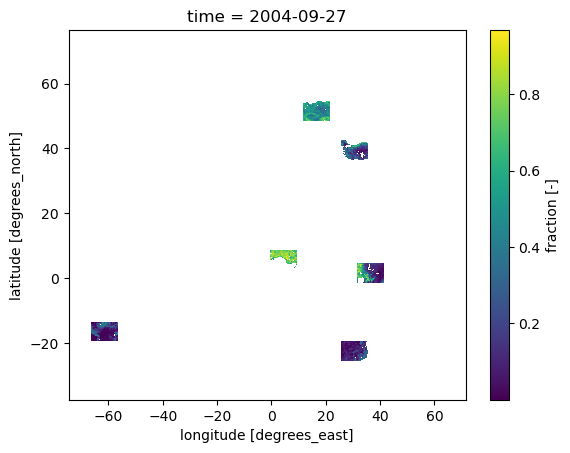

In [14]:
m = output_writer.zarr_file.fvc_ano_hat.isel(time=1000)
m.plot()

In [15]:
m = output_writer.zarr_file.fvc_ano_vhat.isel(time=1000)
m.plot()

AttributeError: 'Dataset' object has no attribute 'fvc_ano_vhat'

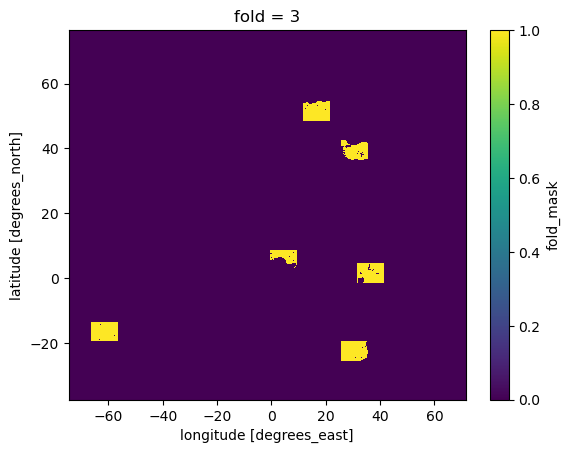

In [ ]:
mask_sel = mask
mask_sel.plot()

In [17]:
m.encoding

{'chunks': (300, 20, 20),
 'preferred_chunks': {'time': 300, 'lat': 20, 'lon': 20},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [19]:
import torch.multiprocessing as mp
from time import sleep

In [30]:
def fun(a):
    print(a)
    sleep(2)

processes = []
for i in range(10):
    a = i * 2
    process = mp.Process(target=fun, args=(a,))
    processes.append(process)
    del a
    process.start()
    sleep(0.2)

for process in processes:
    process.join()


0
2
4
6
8
10
12
14
16
18


In [28]:
p = processes[0]

In [29]:
p.is_alive()

False

In [33]:
l = [1, 2, 3]

TypeError: list indices must be integers or slices, not list